# Laboratorio di simulazione numerica

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import string
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

### Exercise 05.1

In this exercise I sampled the probability distribution of the position of an electron in two selected eigenstates of a hydrogen atom, using the Metropolis algorithm.
To propose the next step in the chain I used:

- a multivariate uniform transition probability, drawing the new position from a cube (centred on the previous position),
- a multivariate Gaussian transition probability, drawing the new position from a normal distribution centred on the previous position.

The parameters in the two cases were tuned in order to get an acceptance ratio of roughly 1/2.

#### Estimation of the equilibration time
Plotting the radius at each step sampled by the Metropolis algorithm, using both types of the transition probability, I make a guess at the equilibration time.
The data in this plot can be generated by running `./exercise05_raw close` (that starts from a point closer to the origin) and `./exercise05_raw far` (that starts from a point farther from the origin).

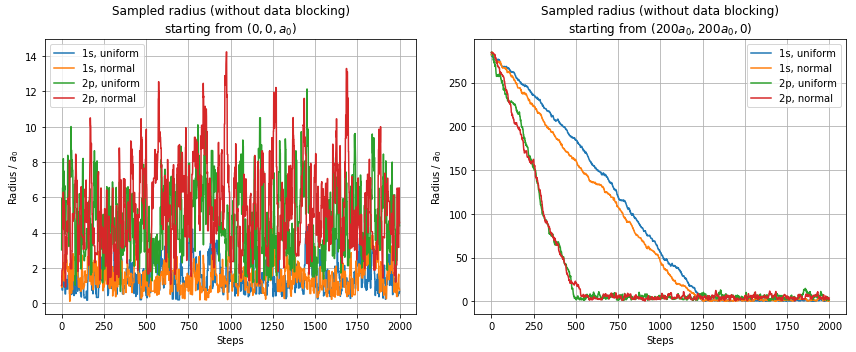

In [2]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes = axes.flatten()

radius_raw = np.loadtxt("close/radius_raw.dat", skiprows = 1)
axes[0].plot(radius_raw)
axes[0].set_title("Sampled radius (without data blocking)\n" r"starting from $(0,0,a_0)$")

radius_raw = np.loadtxt("far/radius_raw.dat", skiprows = 1)
axes[1].plot(radius_raw)
axes[1].set_title("Sampled radius (without data blocking)\n" r"starting from $(200a_0, 200a_0, 0)$")

for ax in axes:
    ax.set_xlabel("Steps")
    ax.set_ylabel(r"Radius / $a_0$")
    ax.grid(True)
    ax.legend(["1s, uniform", "1s, normal", "2p, uniform", "2p, normal"])

fig.tight_layout()
plt.show()

It is very clear from these plots that the system starting from the point closer to the origin does not need any equilibration, while the one starting farther from the origin shows a manifestly different behaviour at the beginning of the simulation.
I estimate that the time for the 2p sampling, for the latter, is around 600 steps, while for the 1s sampling it is around 1250 steps.

#### Study of the optimal block size
To guess the optimal size of the block to use to analyse the data, I study the autocorrelation of the samples.
The data used for the following plots is generated from a variant of `./exercise05_raw`, named `./exercise05_raw_equilibrated`, that implements the equilibraton of the sample, with the results of the previous cells: it can be obtained by running `./exercise05_raw_equilibrated close` and `./exercise05_raw_equilibrated far`.

In [29]:
def autocovariance(series, lag):
    n = len(series)
    mean = 0
    for x in series:
        mean += x
    mean /= n
    c = 0
    for i in range(n - lag):
        c += (series[i] - mean)*(series[i + lag] - mean)
    return c / n

def autocorrelation(series, lag):
    return autocovariance(series, lag) / autocovariance(series, 0)

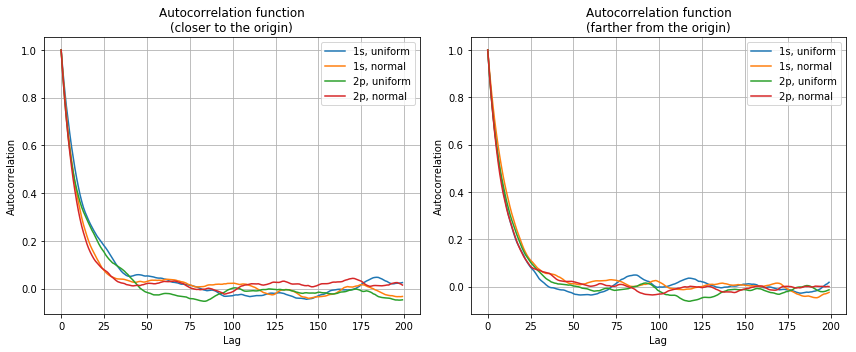

In [54]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes = axes.flatten()
max_lag = 200
    
radius_raw = np.loadtxt("close/radius_raw_equilibrated.dat", skiprows = 1, unpack = True)

for sample in radius_raw:
    axes[0].plot([autocorrelation(sample, t) for t in range(max_lag)])
axes[0].set_title("Autocorrelation function\n(closer to the origin)")

radius_raw = np.loadtxt("far/radius_raw_equilibrated.dat", skiprows = 1, unpack = True)

for sample in radius_raw:
    axes[1].plot([autocorrelation(sample, t) for t in range(max_lag)])
axes[1].set_title("Autocorrelation function\n(farther from the origin)")

for ax in axes:
    ax.grid(True)
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    ax.legend(["1s, uniform", "1s, normal", "2p, uniform", "2p, normal"])

fig.tight_layout()
plt.show()

These plots suggest that the autocorrelation function, in all cases, has an exponential behaviour.
By fitting the data with a function of the form $e^{-t/\tau}$, $t$ being the lag, I can find the parameter $\tau$, the *autocorrelation length*: this determines the optimal block size as $2\tau$.
Since the samples that used the uniform transition probability seem to behave sligthly differently from those with the normal transition probability, I will fit the data separately for each one (choosing the 1s or 2p eigenstate makes a negligible difference).

In [60]:
max_lag = 200

def autocorrelation_fit(t, t0):
    return [np.exp(-x / t0) for x in t]
    # curve_fit from scipy expects the function to be vectorised.

print("Starting closer to the origin:")
radius_raw = np.loadtxt("close/radius_raw_equilibrated.dat", skiprows = 1, unpack = True)

acf = [autocorrelation(radius_raw[0], t) for t in range(max_lag)]
autocorrelation_time, variance = curve_fit(autocorrelation_fit, range(max_lag), acf, p0 = 1)
print("[1s-uniform] Autocorrelation length: "
      + str(autocorrelation_time[0]) + " +- "
      + str(np.sqrt(variance[0][0]))
     )

acf = [autocorrelation(radius_raw[1], t) for t in range(max_lag)]
autocorrelation_time, variance = curve_fit(autocorrelation_fit, range(max_lag), acf, p0 = 1)
print("[1s-normal] Autocorrelation length: "
      + str(autocorrelation_time[0]) + " +- "
      + str(np.sqrt(variance[0][0]))
     )

print("Starting farther from the origin:")
radius_raw = np.loadtxt("far/radius_raw_equilibrated.dat", skiprows = 1, unpack = True)

acf = [autocorrelation(radius_raw[0], t) for t in range(max_lag)]
autocorrelation_time, variance = curve_fit(autocorrelation_fit, range(max_lag), acf, p0 = 1)
print("[1s-uniform] Autocorrelation length: "
      + str(autocorrelation_time[0]) + " +- "
      + str(np.sqrt(variance[0][0]))
     )

acf = [autocorrelation(radius_raw[1], t) for t in range(max_lag)]
autocorrelation_time, variance = curve_fit(autocorrelation_fit, range(max_lag), acf, p0 = 1)
print("[1s-normal] Autocorrelation length: "
      + str(autocorrelation_time[0]) + " +- "
      + str(np.sqrt(variance[0][0]))
     )

Starting closer to the origin:
[1s-uniform] Autocorrelation length: 13.135713176152176 +- 0.18723819259044958
[1s-normal] Autocorrelation length: 9.98587688349217 +- 0.1276003909152486
Starting farther from the origin:
[1s-uniform] Autocorrelation length: 9.860187708364979 +- 0.1342264125354642
[1s-normal] Autocorrelation length: 11.788021669148412 +- 0.11132066824316571


#### Average radius

Using the information gathered in the cells above, I finally calculated the average radius of the given eigenstates. 
The following plots show the evolution of the average value and its standard deviation as the number of steps, and blocks, increases.
For the sake of simplicity I used a block size of 30 steps for all simulations, enough to cover twice the autocorrelation length in all four cases described in the cell above.

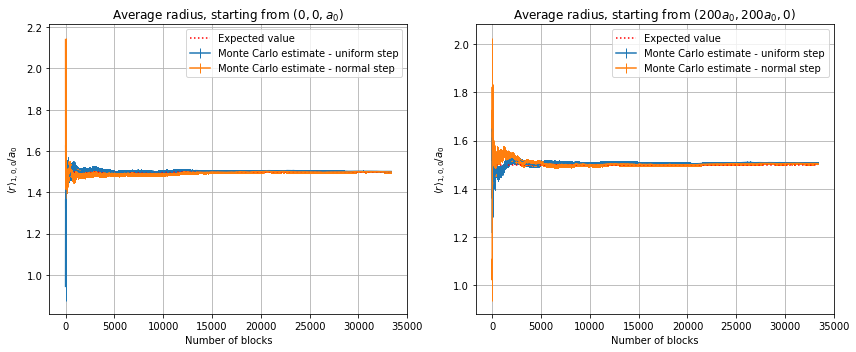

In [63]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes = axes.flatten()

radius_1s_far = np.loadtxt("close/1s_radius_avg.dat", unpack = True, skiprows = 1)

axes[0].errorbar(
    range(1, len(radius_1s_far[0]) + 1),
    radius_1s_far[0],
    yerr = radius_1s_far[1],
    elinewidth = 1,
    label = "Monte Carlo estimate - uniform step"
)
axes[0].errorbar(
    range(1, len(radius_1s_far[2]) + 1),
    radius_1s_far[2],
    yerr = radius_1s_far[3],
    elinewidth = 1,
    label = "Monte Carlo estimate - normal step"
)
axes[0].hlines(
    3/2,
    0,
    len(radius_1s_far[0]),
    colors = "red",
    linestyle = "dotted",
    label = "Expected value"
)
axes[0].set_title("Average radius of the 1s eigenstate,\n" r"starting from $(0,0,a_0)$")
axes[0].set_ylabel(r"$\langle r\rangle_{1,0,0} / a_0$")
axes[0].set_xlabel("Number of blocks")
axes[0].legend()
axes[0].grid(True)

radius_1s_far = np.loadtxt("far/1s_radius_avg.dat", unpack = True, skiprows = 1)

axes[1].errorbar(
    range(1, len(radius_1s_far[0]) + 1),
    radius_1s_far[0],
    yerr = radius_1s_far[1],
    elinewidth = 1,
    label = "Monte Carlo estimate - uniform step"
)
axes[1].errorbar(
    range(1, len(radius_1s_far[2]) + 1),
    radius_1s_far[2],
    yerr = radius_1s_far[3],
    elinewidth = 1,
    label = "Monte Carlo estimate - normal step"
)
axes[1].hlines(
    3/2,
    0,
    len(radius_1s_far[0]),
    colors = "red",
    linestyle = "dotted",
    label = "Expected value"
)
axes[1].set_title("Average radius of the 1s eigenstate,\n" r"starting from $(200a_0, 200a_0, 0)$")
axes[1].set_ylabel(r"$\langle r\rangle_{1,0,0} / a_0$")
axes[1].set_xlabel("Number of blocks")
axes[1].legend()
axes[1].grid(True)

fig.tight_layout()
plt.show()

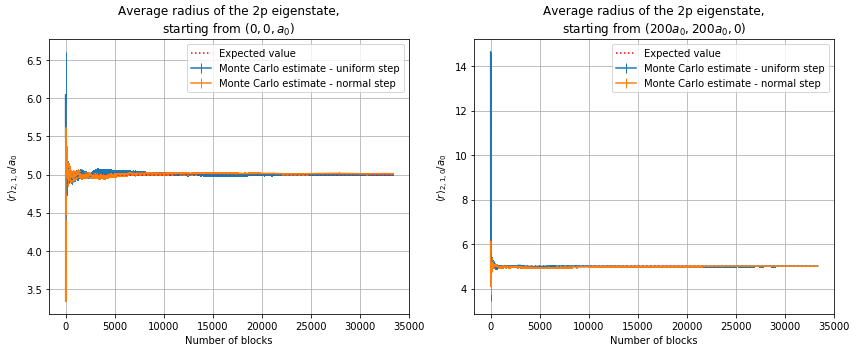

In [66]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes = axes.flatten()

radius_2p_far = np.loadtxt("close/2p_radius_avg.dat", unpack = True, skiprows = 1)

axes[0].errorbar(
    range(1, len(radius_2p_far[0]) + 1),
    radius_2p_far[0],
    yerr = radius_2p_far[1],
    elinewidth = 1,
    label = "Monte Carlo estimate - uniform step"
)
axes[0].errorbar(
    range(1, len(radius_2p_far[2]) + 1),
    radius_2p_far[2],
    yerr = radius_2p_far[3],
    elinewidth = 1,
    label = "Monte Carlo estimate - normal step"
)
axes[0].hlines(
    5,
    0,
    len(radius_2p_far[0]),
    colors = "red",
    linestyle = "dotted",
    label = "Expected value"
)
axes[0].set_title("Average radius of the 2p eigenstate,\n" r"starting from $(0,0,a_0)$")
axes[0].set_ylabel(r"$\langle r\rangle_{2,1,0} / a_0$")
axes[0].set_xlabel("Number of blocks")
axes[0].legend()
axes[0].grid(True)

radius_2p_far = np.loadtxt("far/2p_radius_avg.dat", unpack = True, skiprows = 1)

axes[1].errorbar(
    range(1, len(radius_2p_far[0]) + 1),
    radius_2p_far[0],
    yerr = radius_2p_far[1],
    elinewidth = 1,
    label = "Monte Carlo estimate - uniform step"
)
axes[1].errorbar(
    range(1, len(radius_2p_far[2]) + 1),
    radius_2p_far[2],
    yerr = radius_2p_far[3],
    elinewidth = 1,
    label = "Monte Carlo estimate - normal step"
)
axes[1].hlines(
    5,
    0,
    len(radius_2p_far[0]),
    colors = "red",
    linestyle = "dotted",
    label = "Expected value"
)
axes[1].set_title("Average radius of the 2p eigenstate,\n" r"starting from $(200a_0, 200a_0, 0)$")
axes[1].set_ylabel(r"$\langle r\rangle_{2,1,0} / a_0$")
axes[1].set_xlabel("Number of blocks")
axes[1].legend()
axes[1].grid(True)

fig.tight_layout()
plt.show()

#### Pictures of the sampled probability functions

##### 1s eigenstate
The following plots show the distribution in space of the sampled points, using $\lvert\psi_{1,0,0}\rvert^2$ as the probability distribution, starting from the two points described above.
I used the algorithm with the uniform distribution only.
Both system were equilibrated before the actual sampling was recorded.

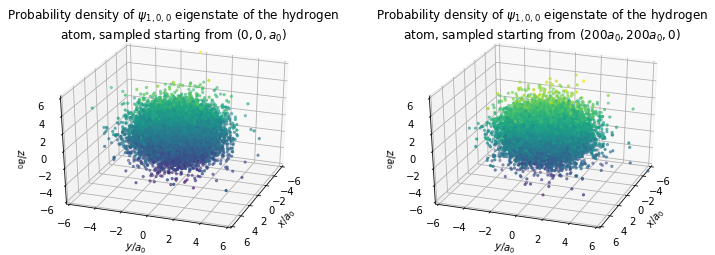

In [77]:
fig = plt.figure(figsize = plt.figaspect(0.33))
# Set up a figure three times as wide as it is tall

ax = fig.add_subplot(1, 2, 1, projection = "3d")
x, y, z = np.loadtxt("close/1s_sampled_points_uniform.dat", unpack = True)
ax.scatter(x, y, z, c = z, marker = ".")
ax.set_xlabel(r"$x / a_0$")
ax.set_ylabel(r"$y / a_0$")
ax.set_zlabel(r"$z / a_0$")
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_zlim(-6, 6)
ax.set_title(r"Probability density of $\psi_{1,0,0}$ eigenstate of the hydrogen"
             "\natom, sampled starting from " r"$(0,0,a_0)$")
ax.view_init(30, 20)

ax = fig.add_subplot(1, 2, 2, projection = "3d")
x, y, z = np.loadtxt("far/1s_sampled_points_uniform.dat", unpack = True)
ax.scatter(x, y, z, c = z, marker = ".")
ax.set_xlabel(r"$x / a_0$")
ax.set_ylabel(r"$y / a_0$")
ax.set_zlabel(r"$z / a_0$")
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_zlim(-6, 6)
ax.set_title(r"Probability density of $\psi_{1,0,0}$ eigenstate of the hydrogen"
             "\natom, sampled starting from " r"$(200a_0, 200a_0, 0)$")
ax.view_init(30, 20)

plt.show()

There seem to be no remarkable differences between the two cases.

##### 2p eigenstate
The same as above, but using $\lvert\psi_{2,1,0}\rvert^2$ as the probability distribution.

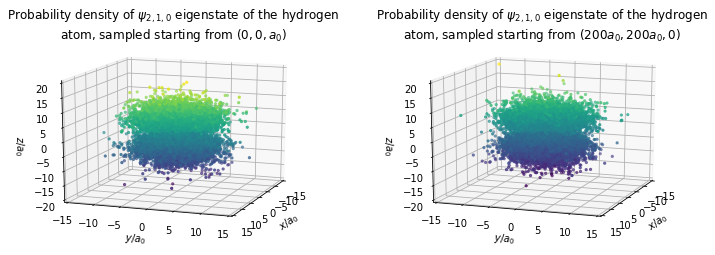

In [79]:
fig = plt.figure(figsize = plt.figaspect(0.33))
# Set up a figure three times as wide as it is tall

ax = fig.add_subplot(1, 2, 1, projection = "3d")
x, y, z = np.loadtxt("close/2p_sampled_points_uniform.dat", unpack = True)
ax.scatter(x, y, z, c = z, marker = ".")
ax.set_xlabel(r"$x / a_0$")
ax.set_ylabel(r"$y / a_0$")
ax.set_zlabel(r"$z / a_0$")
ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
ax.set_zlim(-20, 20)
ax.set_title(r"Probability density of $\psi_{2,1,0}$ eigenstate of the hydrogen"
             "\natom, sampled starting from " r"$(0,0,a_0)$")
ax.view_init(15, 20)

ax = fig.add_subplot(1, 2, 2, projection = "3d")
x, y, z = np.loadtxt("far/2p_sampled_points_uniform.dat", unpack = True)
ax.scatter(x, y, z, c = z, marker = ".")
ax.set_xlabel(r"$x / a_0$")
ax.set_ylabel(r"$y / a_0$")
ax.set_zlabel(r"$z / a_0$")
ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
ax.set_zlim(-20, 20)
ax.set_title(r"Probability density of $\psi_{2,1,0}$ eigenstate of the hydrogen"
             "\natom, sampled starting from " r"$(200a_0, 200a_0, 0)$")
ax.view_init(15, 20)

plt.show()

Here, too, I see no substantial differences between the two plots.